# Import libraries

In [42]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib import rc
from GMHI import GMHI

# Set constants

In [55]:
# set figure details
figsize = (10, 10)
dpi = 200

# set colors
healthy_color = "steelblue"
nonhealthy_color = 'orange'

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

filename = "performance_per_study.svg"

# Load data

In [50]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "is_healthy.csv"), index_col=[0, 1])
GMHI2_scores_cv = pd.read_csv(os.path.join(config.PREDICTION_DIR, "GMHI2_scores_cv.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_cv.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-23  SAMEA3879547        0.019774                     0.019774   
         SAMEA3879551        0.000000                     0.000000   
         SAMEA3879543        0.003253                     0.003253   
         SAMEA3879565        0.008863                     0.008863   
         SAMEA3879546        0.000048                     0.000048   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-23  SAMEA3879547                                            0.019774   
         SAMEA3879551                                            0.000000   
         SAMEA3879543                                            0.003253   
         SAMEA3879565                                            0.008863   
         SAMEA3879546                                            0.000048   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-23  SAMEA3879547                                               0.019774                      
         SAMEA3879551                                               0.000000                      
         SAMEA3879543                                               0.003253                      
         SAMEA3879565                                               0.008863                      
         SAMEA3879546                                               0.000048                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-23  SAMEA3879547                                               0.019774                                             
         SAMEA3879551                                               0.000000                                             
         SAMEA3879543                                               0.003253                                             
         SAMEA3879565                                               0.008863                                             
         SAMEA3879546                                               0.000048                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-23  SAMEA3879547                                               0.019774                                                                   
         SAMEA3879551                                               0.000000                                                                   
         SAMEA3879543                                               0.003253                                                                   
         SAMEA3879565                                               0.008863                                                                   
         SAMEA3879546                                               0.000048                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-23  SAMEA3879547                                               0.019774              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-23  SAMEA3879547                              True
         SAMEA3879551                              True
         SAMEA3879543                              True
         SAMEA3879565                              True
         SAMEA3879546                              True

GMHI2_cv
Study_ID Sample Accession          
GMHI-23  SAMEA3879547      1.884788
         SAMEA3879551     -0.062656
         SAMEA3879543     -0.890399
         SAMEA3879565      0.468921
         SAMEA3879546      1.171292

# Rank order and plot

In [51]:
cutoff = 0.1

def get_balanced_study(index_scores, y):
    scores = []
    for study in np.unique(index_scores.index.get_level_values(0)):
        y_curr = y.loc[study]
        index_curr = index_scores.loc[study]
        idx = (abs(index_curr) >= cutoff).values
        score = balanced_accuracy_score(y_curr[idx], index_curr[idx] > 0)
        scores.append(
            {
                "study" : study,
                "score" : score
            }
        )
        
    df = pd.DataFrame(scores)
    return df.set_index("study")

In [52]:
GMHI2_study_scores = get_balanced_study(GMHI2_scores_cv, y)
GMHI2_study_scores = GMHI2_study_scores.sort_values("score", ascending=False)
print(GMHI2_study_scores.mean())
GMHI2_study_scores

score    0.729832
dtype: float64


,score
study,
P9,1.000000
P113,0.986842
P88,0.977528
P17,0.952830
P77,0.950000
...,...
P135,0.525641
P32,0.517308
P15,0.511364


In [53]:
colors = ["steelblue" if 0 < float(y.loc[s].mean()) < 1 else "orange" for s in GMHI2_study_scores.index]

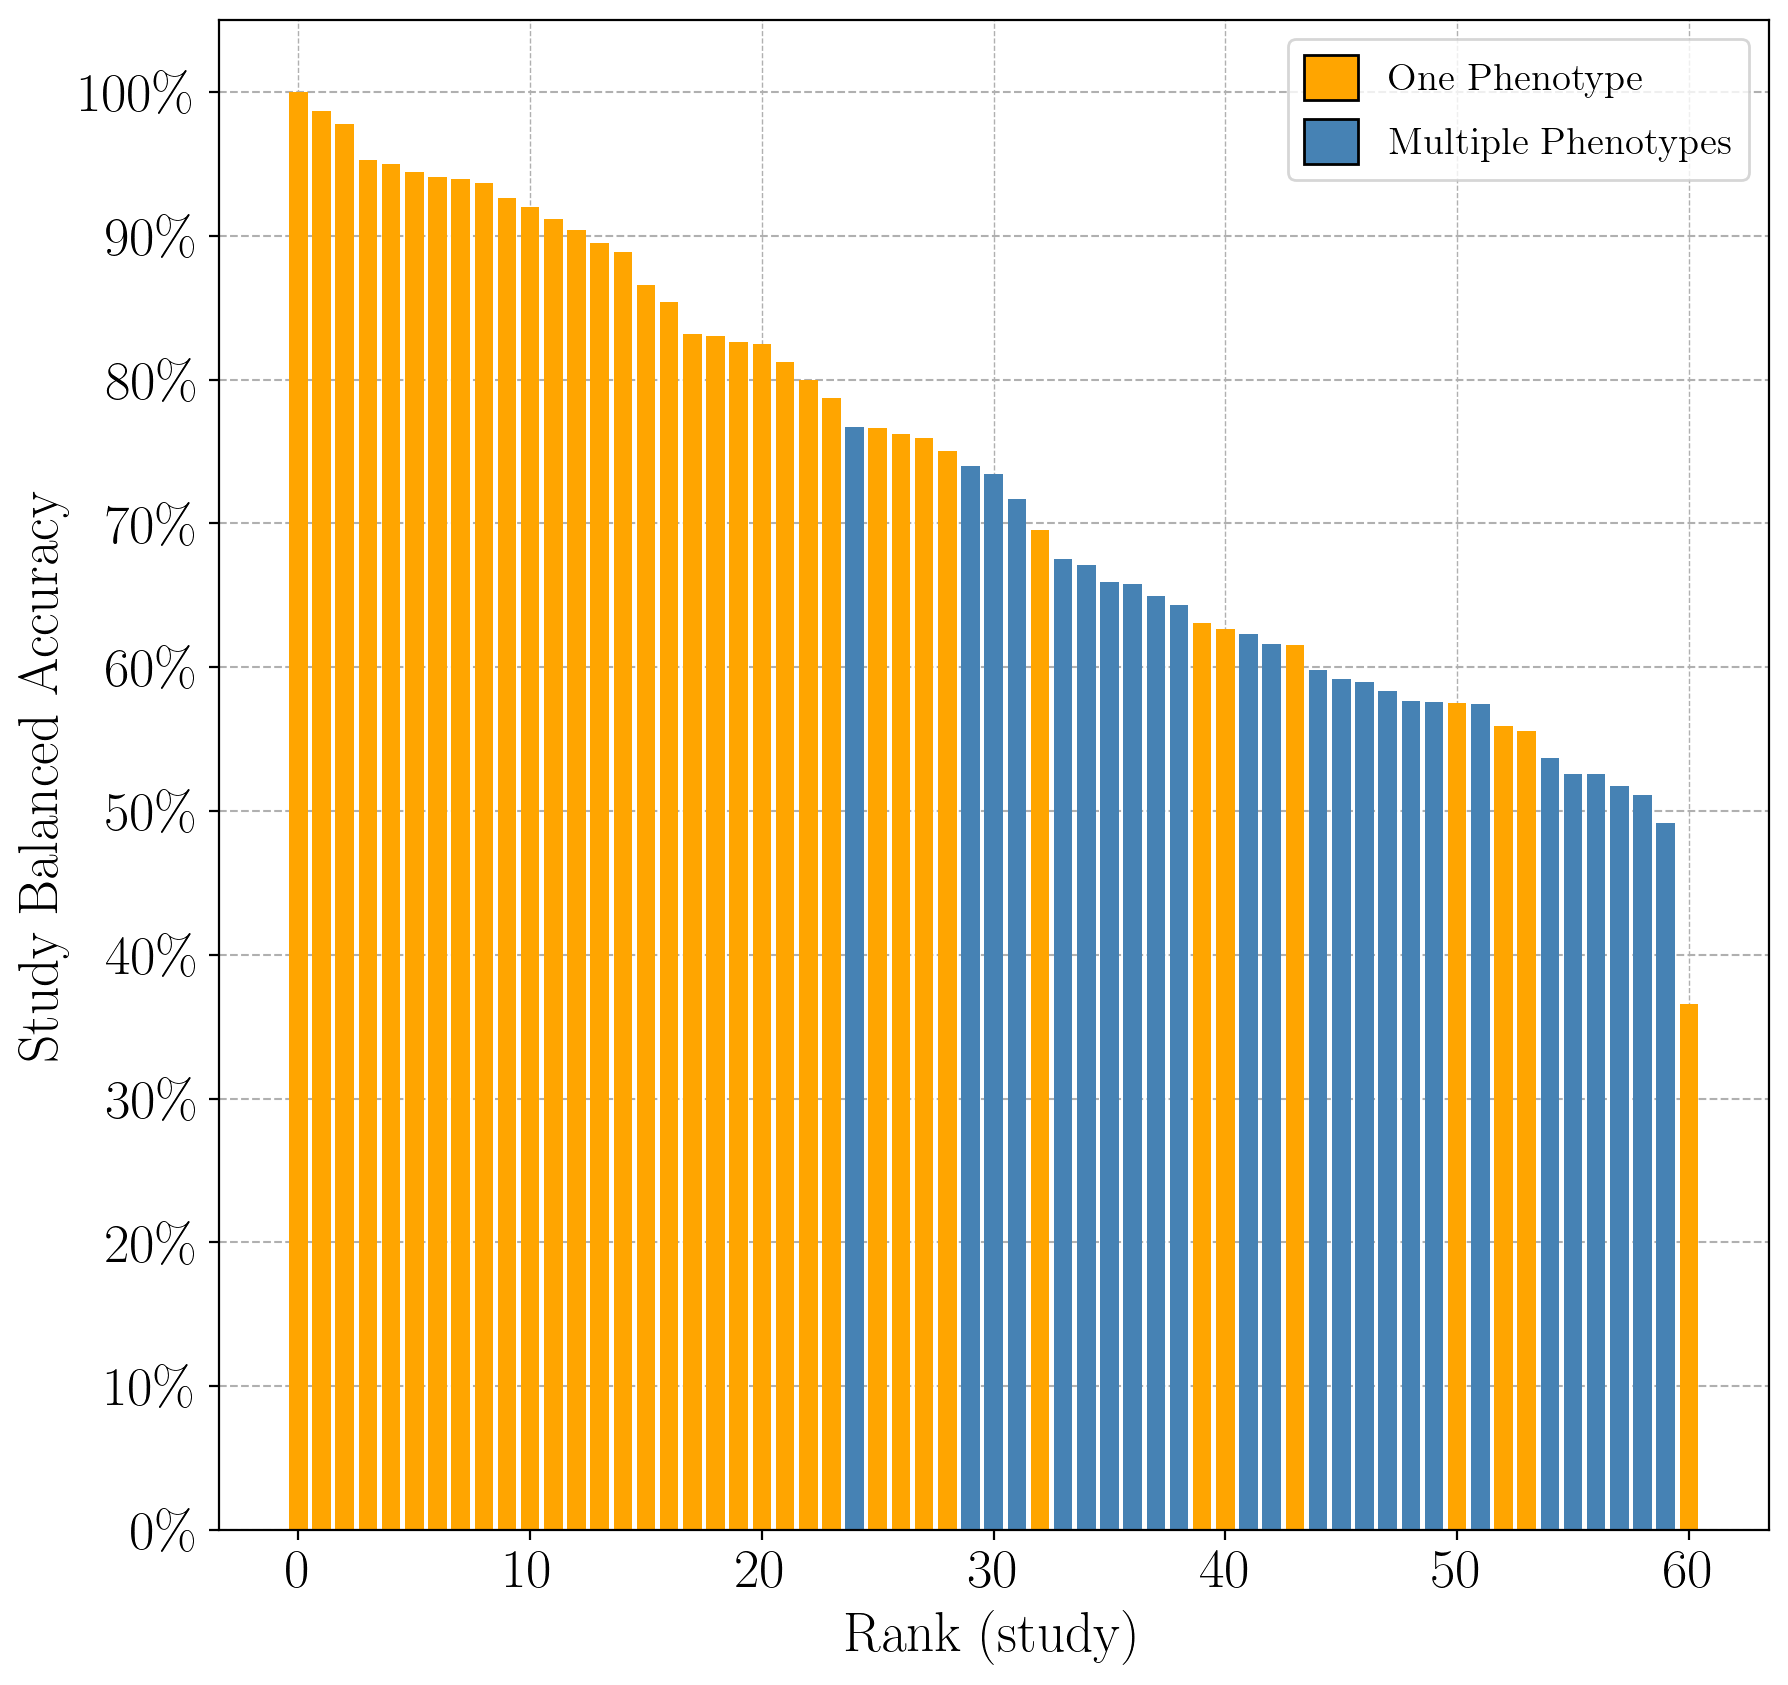

In [57]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = plt.gca()

plt.bar(np.arange(0, GMHI2_study_scores.shape[0]), GMHI2_study_scores["score"].values, color=colors)
ax.tick_params(axis="both", labelsize=20)

ax.set_ylabel("Study Balanced Accuracy", fontsize=20)
ax.set_xlabel("Rank (study)", fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1))

ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

handles = [
    Patch(facecolor="orange", edgecolor="k", label="One Phenotype", alpha=1),
    Patch(facecolor="steelblue", edgecolor="k", label="Multiple Phenotypes", alpha=1),
]

plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend(handles=handles, prop={'size': 14}, loc=1, handlelength=1.4, handleheight=1.4)

ax.grid(linestyle = '--', linewidth = 0.75, axis="y")
plt.savefig(os.path.join(config.FIGURE_DIR, filename))